In [1]:
import numpy as np
import cv2
import reid.datasets
import matplotlib.pyplot as plt
%matplotlib inline
import os.path as osp

from reid.utils.data.dataset import _pluck
from reid.datasets import CUHK01

In [2]:
OUTPUT_SHAPE = (H, W, _) = (128, 48, 3)

In [3]:
!ls ./datasets

cuhk01			  market-1501		    viper_test_correct.npz
cuhk03			  market_test_correct.npz   viper_test.npz
cuhk03_test.npz		  market_test.npz	    viper_train_correct.npz
cuhk03_train_correct.npz  market_train_correct.npz  viper_train.npz
cuhk03_train.npz	  market_train.npz
duke			  viper


In [6]:
dataset = CUHK01('./datasets/cuhk01', download=False)

CUHK01 dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |   385 |     1540
  val      |   100 |      400
  trainval |   485 |     1940
  query    |   486 |     1944
  gallery  |   486 |     1944


In [9]:
dataset.train[:10]

[('00000000_00_0000.png', 0, 0),
 ('00000000_00_0001.png', 0, 0),
 ('00000000_01_0000.png', 0, 1),
 ('00000000_01_0001.png', 0, 1),
 ('00000001_00_0000.png', 1, 0),
 ('00000001_00_0001.png', 1, 0),
 ('00000001_01_0000.png', 1, 1),
 ('00000001_01_0001.png', 1, 1),
 ('00000002_00_0000.png', 2, 0),
 ('00000002_00_0001.png', 2, 0)]

In [10]:
dataset.val[:10]

[('00000050_00_0000.png', 0, 0),
 ('00000050_00_0001.png', 0, 0),
 ('00000050_01_0000.png', 0, 1),
 ('00000050_01_0001.png', 0, 1),
 ('00000055_00_0000.png', 1, 0),
 ('00000055_00_0001.png', 1, 0),
 ('00000055_01_0000.png', 1, 1),
 ('00000055_01_0001.png', 1, 1),
 ('00000067_00_0000.png', 2, 0),
 ('00000067_00_0001.png', 2, 0)]

# Extraindo o dataset

## Treinamento

In [11]:
 def load_img_and_resize(fpath, out_shape=(128, 48, 3)):
    """ Carrega a imagem, transforma BGR->RGB e redimensiona para out_shape. """
    img = cv2.cvtColor(cv2.imread(fpath),cv2.COLOR_BGR2RGB)
    if img.shape != out_shape:
        Ho, Wo, _ = out_shape
        img = cv2.resize(img, (Wo, Ho), interpolation=cv2.INTER_AREA)
    # Adiciona uma dimensão para poder concatenar as imagens
    return img.reshape((1,) + out_shape)

### Carrega as imagens e as labels (person IDs)

In [23]:
X_train = []
y_train = []
cam_ids_train = []

for (fname, pid, cam_id) in dataset.train:
    fpath = osp.join(dataset.root, 'images', fname)
    img = load_img_and_resize(fpath, out_shape=OUTPUT_SHAPE)
    X_train.append(img)
    y_train.append(pid)
    cam_ids_train.append(cam_id)
    
X_train = np.concatenate(X_train, axis=0)
y_train = np.asarray(y_train, dtype=int)
cam_ids_train = np.asarray(cam_ids_train, dtype=np.uint8)

In [20]:
print(len(X_train), X_train[0].shape, X_train[0].dtype, X_train[0].min(), X_train[0].max())

1540 (128, 48, 3) uint8 3 255


In [21]:
print(len(y_train), y_train.shape, y_train.dtype, y_train.min(), y_train.max())

1540 (1540,) int64 0 384


In [24]:
print(len(cam_ids_train), cam_ids_train.shape, cam_ids_train.dtype, cam_ids_train.min(), cam_ids_train.max())

1540 (1540,) uint8 0 1


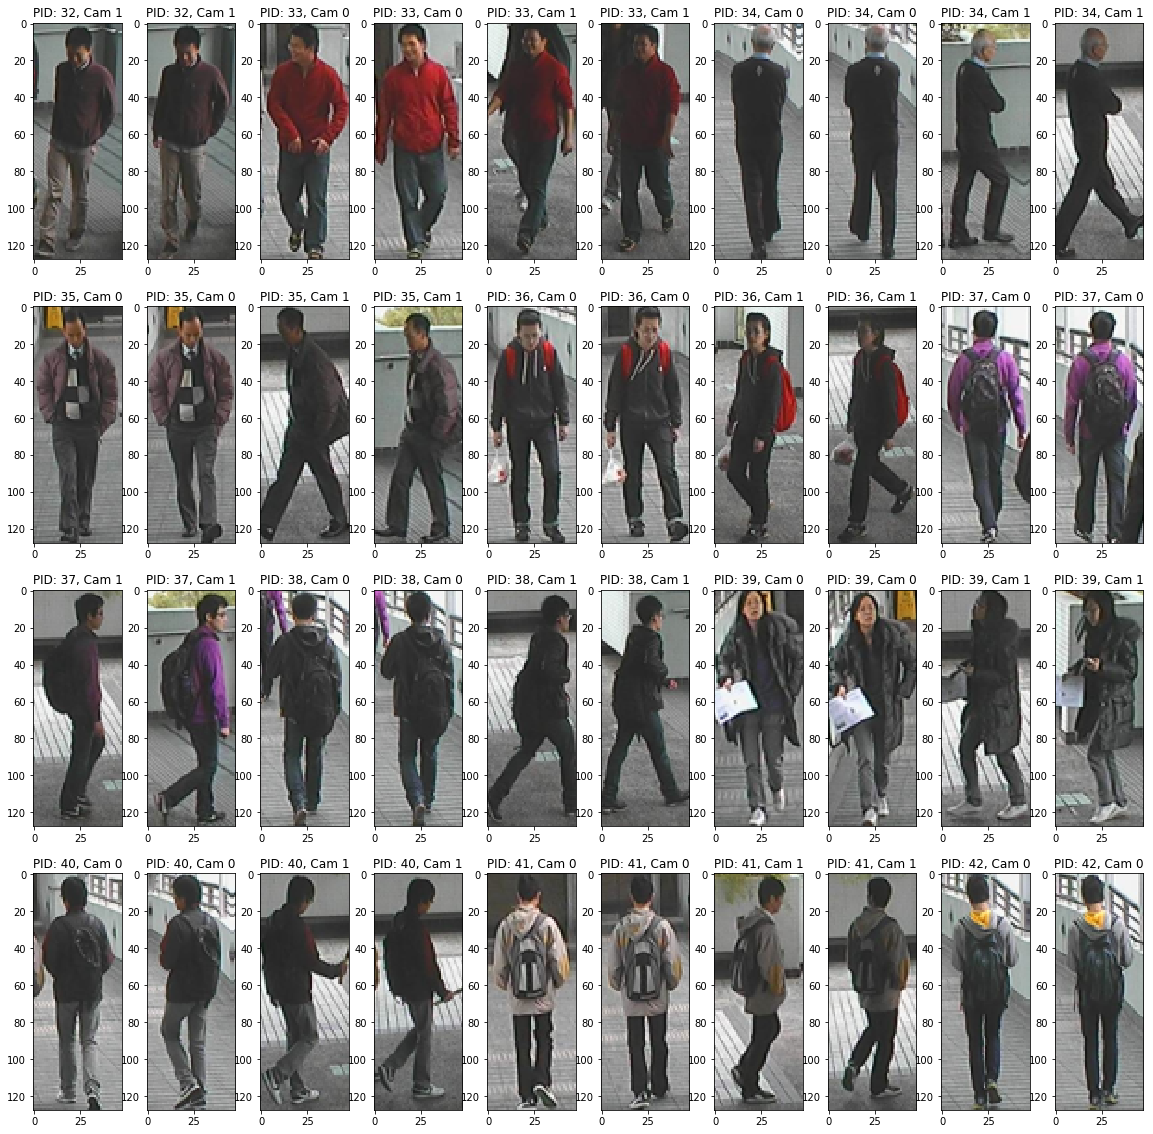

In [25]:
offset = 130
plt.figure(figsize=(20, 20))
for i in range(40):
    plt.subplot(4,10,i+1)
    img = X_train[offset+i]
    plt.imshow(img)
    plt.title('PID: {}, Cam {}'.format(y_train[offset+i], cam_ids_train[offset+i]))

## Validação

In [49]:
X_val = []
y_val = []
cam_ids_val = []

for (fname, pid, cam_id) in dataset.val:
    fpath = osp.join(dataset.root, 'images', fname)
    img = load_img_and_resize(fpath, out_shape=OUTPUT_SHAPE)
    X_val.append(img)
    y_val.append(pid)
    cam_ids_val.append(cam_id)
    
X_val = np.concatenate(X_val, axis=0)
y_val = np.asarray(y_val, dtype=int)
cam_ids_val = np.asarray(cam_ids_val, dtype=np.uint8)

In [27]:
print(len(X_val), X_val[0].shape, X_val[0].dtype, X_val[0].min(), X_val[0].max())

400 (128, 48, 3) uint8 14 218


In [28]:
print(len(y_val), y_val.shape, y_val.dtype, y_val.min(), y_val.max())

400 (400,) int64 0 99


In [50]:
print(len(cam_ids_val), cam_ids_val.shape, cam_ids_val.dtype, cam_ids_val.min(), cam_ids_val.max())

400 (400,) uint8 0 1


In [30]:
print('Número de PIDs diferentes em y_val: ', len(np.unique(y_val)))

Número de PIDs diferentes em y_val:  100


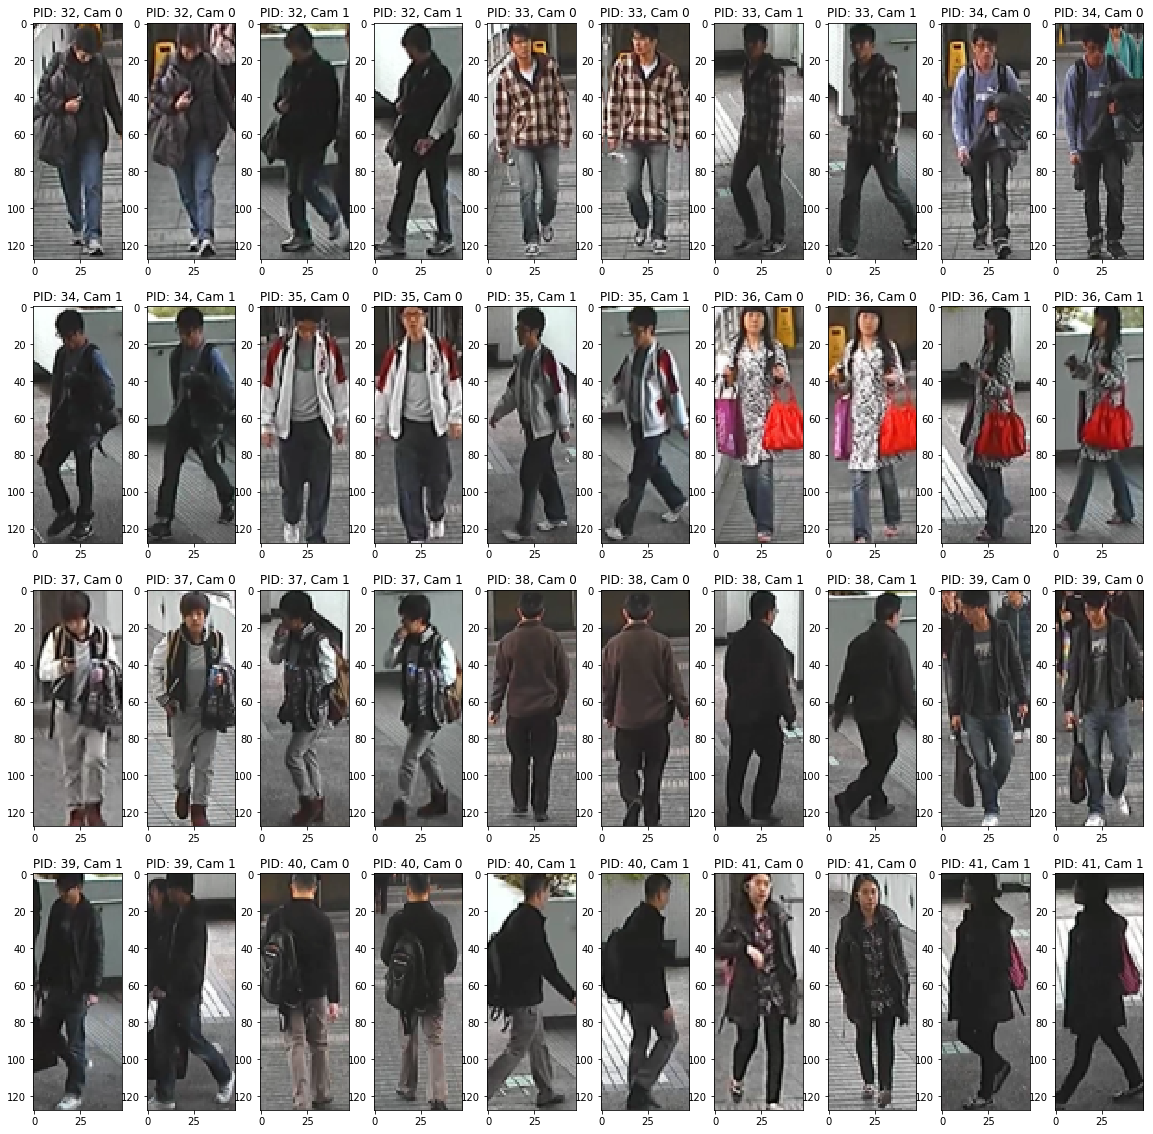

In [52]:
offset = 128
plt.figure(figsize=(20, 20))
for i in range(40):
    plt.subplot(4,10,i+1)
    img = X_val[offset+i]
    plt.imshow(img)
    plt.title('PID: {}, Cam {}'.format(y_val[offset+i], cam_ids_val[offset+i]))

# Query + Gallery

In [33]:
for d in dataset.query[:20]: print(d)

('00000003_00_0000.png', 3, 0)
('00000003_00_0001.png', 3, 0)
('00000003_01_0000.png', 3, 1)
('00000003_01_0001.png', 3, 1)
('00000004_00_0000.png', 4, 0)
('00000004_00_0001.png', 4, 0)
('00000004_01_0000.png', 4, 1)
('00000004_01_0001.png', 4, 1)
('00000006_00_0000.png', 6, 0)
('00000006_00_0001.png', 6, 0)
('00000006_01_0000.png', 6, 1)
('00000006_01_0001.png', 6, 1)
('00000007_00_0000.png', 7, 0)
('00000007_00_0001.png', 7, 0)
('00000007_01_0000.png', 7, 1)
('00000007_01_0001.png', 7, 1)
('00000009_00_0000.png', 9, 0)
('00000009_00_0001.png', 9, 0)
('00000009_01_0000.png', 9, 1)
('00000009_01_0001.png', 9, 1)


In [34]:
print(dataset.split['query'] == dataset.split['gallery'])

True


In [35]:
print(dataset.split['query'])

[3, 4, 6, 7, 9, 10, 12, 13, 17, 18, 23, 24, 27, 30, 31, 33, 34, 35, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 60, 62, 66, 69, 76, 77, 78, 79, 80, 81, 85, 87, 88, 91, 94, 95, 96, 98, 101, 103, 109, 110, 111, 112, 113, 119, 120, 122, 123, 125, 126, 128, 129, 133, 134, 136, 140, 141, 143, 144, 145, 149, 151, 153, 154, 156, 157, 158, 159, 164, 165, 166, 168, 169, 172, 173, 174, 177, 179, 180, 181, 182, 183, 187, 188, 190, 191, 193, 194, 195, 196, 197, 200, 201, 202, 203, 207, 209, 211, 212, 214, 215, 217, 218, 219, 222, 223, 226, 227, 230, 231, 235, 238, 239, 242, 244, 248, 250, 251, 252, 255, 257, 262, 263, 266, 268, 269, 272, 273, 276, 278, 279, 282, 283, 284, 287, 288, 289, 291, 292, 293, 294, 296, 300, 301, 302, 303, 304, 307, 309, 311, 313, 315, 316, 321, 323, 326, 328, 330, 331, 333, 334, 336, 337, 343, 344, 346, 350, 355, 356, 357, 358, 359, 363, 364, 365, 366, 367, 368, 369, 370, 374, 376, 377, 379, 382, 383, 384, 386, 387, 391, 393, 395, 397, 399, 401, 402, 404, 406, 407, 408, 409, 

In [53]:
X_querygal = []
y_querygal = []
cam_ids_querygal = []

for (fname, pid, cam_id) in dataset.query:
    fpath = osp.join(dataset.root, 'images', fname)
    img = load_img_and_resize(fpath, out_shape=OUTPUT_SHAPE)
    X_querygal.append(img)
    y_querygal.append(pid)
    cam_ids_querygal.append(cam_id)


X_querygal = np.concatenate(X_querygal, axis=0)
query_ids, y_querygal = np.unique(y_querygal, return_inverse=True)  # Transforma em IDs consecutivos
cam_ids_querygal = np.asarray(cam_ids_querygal, dtype=np.uint8)

In [43]:
print(len(X_querygal), X_querygal[0].shape, X_querygal[0].dtype, X_querygal[0].min(), X_querygal[0].max())

1944 (128, 48, 3) uint8 10 254


In [44]:
print(len(y_querygal), y_querygal.shape, y_querygal.dtype, y_querygal.min(), y_querygal.max())

1944 (1944,) int64 0 485


In [54]:
print(len(cam_ids_querygal), cam_ids_querygal.shape, cam_ids_querygal.dtype, cam_ids_querygal.min(), cam_ids_querygal.max())

1944 (1944,) uint8 0 1


In [55]:
print(cam_ids_querygal[:15], cam_ids_querygal[-15:])

[0 0 1 1 0 0 1 1 0 0 1 1 0 0 1] [0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]


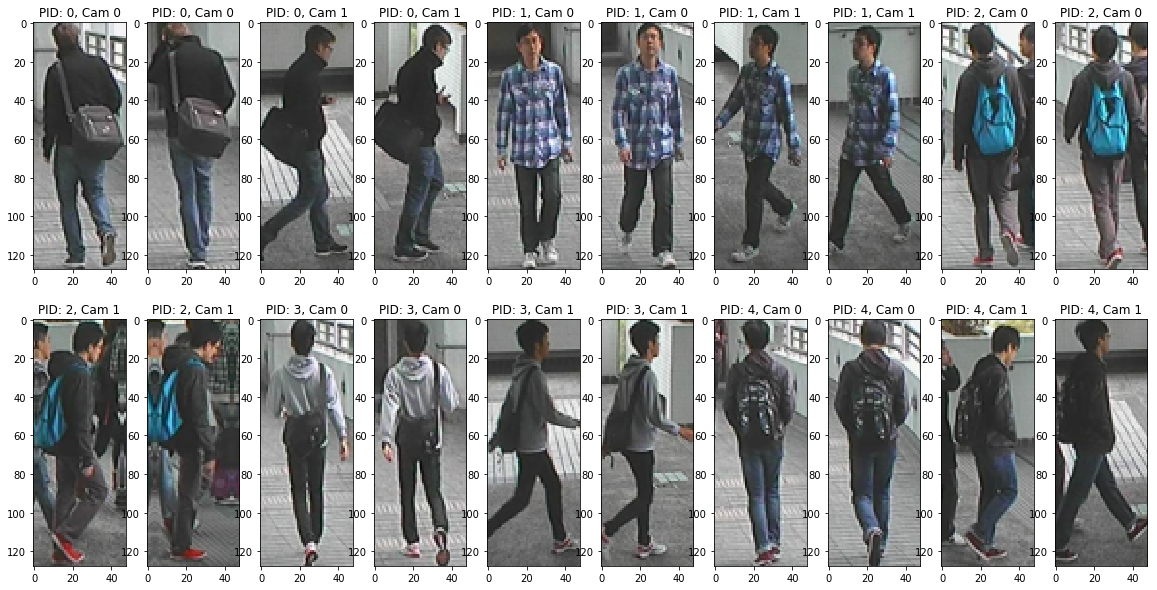

In [56]:
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(2,10,i+1)
    img = X_querygal[i]
    plt.imshow(img)
    plt.title('PID: {}, Cam {}'.format(y_querygal[i], cam_ids_querygal[i]))

# Gallery: são os mesmos IDs de Query



# Salva o arquivo npz

In [57]:
np.savez('./datasets/cuhk01_train_correct', X_train=X_train, y_train=y_train, cam_ids_train=cam_ids_train,
         X_val=X_val, y_val=y_val, cam_ids_val=cam_ids_val)

In [58]:
np.savez('./datasets/cuhk01_test_correct', X_querygal=X_querygal, y_querygal=y_querygal, 
         cam_ids_querygal=cam_ids_querygal)